## Imports

In [1]:
from rich.jupyter import display

from core.utils.logging import setup_logging
setup_logging()
import structlog
logger = structlog.get_logger(__name__)


2025-07-09 17:08:37.384306 [info     ] Logging setup complete.        [core.utils.logging]


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
%load_ext autoreload
%autoreload 2

import os
import json
from tqdm import tqdm

from core.utils.shared import CONFIGS_DIR
from core.config.config import ConfigManager

from core.models.llm.model import LLMModel
from core.models.lmv3.model import LMv3Model

from core.data.utils import get_dataset
from core.data.stats import evaluate_json_response
from core.data.filters import filter_schematisms

from core.data.schematism_parser import SchematismParser
from core.data.translation_parser import Parser


2025-07-09 17:08:52.387273 [info     ] PyTorch version 2.7.0 available. [datasets]


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Loading configuration

In [15]:
config_manager = ConfigManager(configs_dir=CONFIGS_DIR)

llm_config = config_manager.load_config(config_type="llm", config_subtype=, config_name="llmmodelconfig")

lmv3_config = config_manager.load_config(config_type="lmv3", config_subtype=, config_name="lmv3modelconfig")


dataset_config = config_manager.load_config(config_type="dataset", config_subtype=, config_name="datasetconfig")
#
# streamed_dataset_config = config_manager.load_config(
#     config_name="streamed_dataset",
#     config_type="dataset"
# )



2025-07-09 17:32:13.203101 [info     ] Loaded config                  [core.config.config] config={'predictor': {'api_type': 'openrouter', 'template_dir': 'prompts'}, 'interfaces': {'lm_studio': {'model': 'gemma-3-27b-it-qat', 'structured_output': True, 'base_url': 'http://localhost:1234/v1', 'api_key_env_var': 'OPENAI_API_KEY', 'template_dir': 'prompts', 'api_kwargs': {'max_tokens': 4096, 'temperature': 0.1, 'top_p': 0.9}}, 'openrouter': {'model': 'mistralai/pixtral-large-2411', 'base_url': 'https://openrouter.ai/api/v1', 'api_key_env_var': 'OPENROUTER_API_KEY', 'structured_output': True, 'api_kwargs': {'max_tokens': 4096, 'temperature': 0.1, 'top_p': 0.9}}, 'openai': {'model': 'gemma-3-27b-it-qat', 'api_key_env_var': 'OPENAI_API_KEY', 'structured_output': True, 'api_kwargs': {'max_tokens': 4096, 'temperature': 0.1, 'top_p': 0.9}}, 'mistral': {'model': 'mistral-large-latest', 'api_key_env_var': 'MISTRAL_API_KEY', 'structured_output': True, 'template_dir': 'prompts', 'api_kwargs': {'ma

## Loading dataset

In [19]:
dataset = get_dataset(dataset_config, wrapper=True)

Using the latest cached version of the module from /Users/user/.cache/huggingface/modules/datasets_modules/datasets/artpods56--EcclesialSchematisms/a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b (last modified on Thu Jun 26 16:28:14 2025) since it couldn't be found locally at artpods56/EcclesialSchematisms, or remotely on the Hugging Face Hub.


2025-07-06 15:39:27.611534 [warning  ] Using the latest cached version of the module from /Users/user/.cache/huggingface/modules/datasets_modules/datasets/artpods56--EcclesialSchematisms/a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b (last modified on Thu Jun 26 16:28:14 2025) since it couldn't be found locally at artpods56/EcclesialSchematisms, or remotely on the Hugging Face Hub. [datasets.load]


Generating train split:   0%|          | 0/537 [00:00<?, ? examples/s]

2025-07-06 15:39:29.780902 [info     ] Loading label annotations…     [datasets_modules.datasets.artpods56--EcclesialSchematisms.a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b.EcclesialSchematisms]
2025-07-06 15:39:29.778945 [info     ] Loading label annotations…     [datasets_modules.datasets.artpods56--EcclesialSchematisms.a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b.EcclesialSchematisms]
2025-07-06 15:39:29.783473 [info     ] Loading label annotations…     [datasets_modules.datasets.artpods56--EcclesialSchematisms.a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b.EcclesialSchematisms]
2025-07-06 15:39:29.830642 [info     ] Loading label annotations…     [datasets_modules.datasets.artpods56--EcclesialSchematisms.a724fb67b8d27b253099abcec772b48750d32437756298596b42ac20c9a96a1b.EcclesialSchematisms]
2025-07-06 15:39:29.833395 [info     ] Loading label annotations…     [datasets_modules.datasets.artpods56--EcclesialSchematisms.a724fb6

In [20]:
# streamed_dataset = get_dataset(streamed_dataset_config, wrapper=True)
filtered_dataset = dataset.filter(filter_schematisms(["wloclawek_1872"]))


Filter:   0%|          | 0/537 [00:00<?, ? examples/s]

In [21]:
filtered_dataset

DatasetWrapper(
        Dataset({
    features: ['image_pil', 'image', 'width', 'height', 'words', 'bboxes', 'labels', 'conf'],
    num_rows: 121
})
        

## Mappings parser

In [22]:
parser = Parser()

response = parser.parse("lignea et mur", "building_material")
print(response)

dr-mr


In [23]:
filtered_dataset[20]

{'schematism_name': 'wloclawek_1872',
 'image_filename': '0021.jpg',
 'image_pil': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1150x1900>,
 'page_json': {'page_number': '21',
  'deanery': None,
  'entries': [{'parish': 'Połajewo,',
    'dedication': 'SS. Trinitatis',
    'building_material': 'mur.'},
   {'parish': 'Raciążek,',
    'dedication': 'S. Hieron. CZ D.',
    'building_material': None},
   {'parish': 'Sadlno,',
    'dedication': 'S. Nicolaus EC.',
    'building_material': 'mur.'},
   {'parish': 'Sędzin,',
    'dedication': 'S. Matthaeus Ap.',
    'building_material': 'lig.'}]}}

In [24]:
dataset_json = parser.parse_page(filtered_dataset[70]["page_json"])
dataset_json

copied json


{'page_number': '71',
 'deanery': None,
 'entries': [{'parish': 'Bogdanów,',
   'dedication': 'Św. Trójca',
   'building_material': 'mr'},
  {'parish': 'Chabielice,', 'dedication': None, 'building_material': 'dr'},
  {'parish': 'Drużbice,',
   'dedication': 'Marcin Biskup',
   'building_material': 'dr'}]}

## Schematism parser

In [25]:
csv_path = "/Users/user/Projects/AI_Osrodek/data/csv/dane_hasla_with_filename.csv"

# page_info_json = schematism_parser.get_page_info("0174.jpg")
# page_info_json

## Loading models 

In [16]:
%load_ext autoreload
%autoreload 2
llm_model = LLMModel(config=llm_config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2025-07-09 17:32:19.320901 [info     ] Loaded cache from /Volumes/T7/AI_Osrodek/tmp/caches/LLMCache/mistralai_pixtral-large-2411.json [core.caches.llm_cache] model_name=mistralai_pixtral-large-2411
2025-07-09 17:32:19.321570 [info     ] Initializing LLM client...     [core.models.llm.interface]
2025-07-09 17:32:19.326917 [info     ] Testing connection to LLM client... [core.models.llm.interface]
2025-07-09 17:32:21.515001 [info     ] HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK" [httpx]
2025-07-09 17:32:22.408650 [info     ] Successfully connected to OpenAI client. [core.models.llm.interface]


In [17]:
lmv3_model = LMv3Model(config=lmv3_config)

2025-07-09 17:35:12.223893 [info     ] Loaded cache from /Volumes/T7/AI_Osrodek/tmp/caches/LMv3Cache/lmv3cache.json [core.caches.lmv3_cache] checkpoint=artpods56/layoutlmv3_focalloss_4000


In [ ]:
import wandb
from core.utils.wandb_eval import create_eval_table, add_eval_row, create_summary_table
from core.data.stats import evaluate_json_response
from core.models.lmv3.model import ocr_page

from typing import Tuple

run = wandb.init(project="ai-osrodek", name="lmv3_llm_eval", mode="online")

_DEFAULT_FIELDS: Tuple[str, ...] = (
    "page_number",
    "deanery",
    "parish",
    "dedication",
    "building_material",
)
for fld in _DEFAULT_FIELDS:
    for m in ("precision", "recall", "f1", "accuracy"):
        run.define_metric(f"{fld}/{m}", summary="mean")  # auto-aggregates :contentReference[oaicite:2]{index=2}


positive_pages_table = create_eval_table()
negative_pages_table = create_eval_table()
all_true, all_pred = [], []
schematism_parser = None
for i, sample in enumerate(filtered_dataset):
    pil_image = sample["image_pil"]

    schematism_name = sample["schematism_name"]
    image_filename = sample["image_filename"]


    if schematism_parser is None:
        schematism_parser = SchematismParser(csv_path=csv_path, schematism_name=schematism_name)
    elif schematism_parser.schematism_name != schematism_name:
        schematism_parser = SchematismParser(csv_path=csv_path, schematism_name=schematism_name)
    # predictions ------------------------------------------------------------
    lmv3_response = lmv3_model.predict(pil_image)

    ocr_text = ocr_page(pil_image, text_only=True)
    llm_response  = llm_model.predict(pil_image, hints=lmv3_response, ocr_text=ocr_text)
    parsed_llm_response = parser.parse_page(llm_response)


    # print("--- llm response ---")
    # print(json.dumps(llm_response, indent=4, ensure_ascii=False))

    # print("--- parsed llm response ---")
    # print(json.dumps(parsed_llm_response, indent=4, ensure_ascii=False))

    # print("--- metrics ---")
    # print(json.dumps(metrics, indent=4, ensure_ascii=False))
    # # ground truth -----------------------------------------------------------
    page_info_json = schematism_parser.get_page_info(image_filename)

    print(json.dumps(page_info_json, indent=4, ensure_ascii=False))

    # metrics ----------------------------------------------------------------
    metrics = evaluate_json_response(page_info_json, parsed_llm_response)

    # print("_"*25)
    # print("--- llm response ---")
    # print(json.dumps(llm_response, indent=4, ensure_ascii=False))

    # ---- expose metrics as scalars ---------------------------------
    positive_scalar_log = {}
    negative_scalar_log = {}
    step = i                                # use page index as the global step
    for fld in _DEFAULT_FIELDS:
        fld_metrics = metrics.get(fld, {})
        for m in ("precision", "recall", "f1", "accuracy"):
            positive_scalar_log[f"{fld}/{m}"] = float(fld_metrics.get(m, 0.0))
            negative_scalar_log[f"{fld}/{m}"] = float(fld_metrics.get(m, 0.0))

      # one call per page  :contentReference[oaicite:3]{index=3}

    # all_true.extend(entry["label"] for entry in page_info_json["entries"])
    # all_pred.extend(entry["label"] for entry in parsed_llm_response["entries"])
    # log --------------------------------------------------------------------
    if len(page_info_json["entries"]) != 0:
        run.log({"positive_scalar_log":positive_scalar_log}, step=step) 
        add_eval_row(
            positive_pages_table,
            lmv3_response=lmv3_response,
            raw_llm_response=llm_response,
            sample_id=image_filename,
            pil_image=pil_image,
            page_info_json=page_info_json,
            parsed_llm_response=parsed_llm_response,
            metrics=metrics,
        )
    else:
        run.log({"negative_scalar_log":negative_scalar_log}, step=step) 
        add_eval_row(
            negative_pages_table,
            lmv3_response=lmv3_response,
            raw_llm_response=llm_response,
            sample_id=image_filename,
            pil_image=pil_image,
            page_info_json=page_info_json,
            parsed_llm_response=parsed_llm_response,
            metrics=metrics,
        )   

summary_positive_pages_table = create_summary_table(positive_pages_table)
summary_negative_pages_table = create_summary_table(negative_pages_table)

run.log({
    "positive_pages_table": positive_pages_table,
    "negative_pages_table": negative_pages_table,
    "positive_pages_summary": summary_positive_pages_table,
    "negative_pages_summary": summary_negative_pages_table,
})

# cm = wandb.plot.confusion_matrix(
#          y_true=all_true, preds=all_pred,
#          class_names=sorted(set(all_true + all_pred))
#  )

run.log({"positive_pages_table": positive_pages_table, "negative_pages_table": negative_pages_table})
run.finish()



In [28]:
sample = filtered_dataset[6]["image_pil"]

d
Joannes Jakubowski Dec. for. Petric., loc. ten. Asses,
Cons. For. Petr.
Anton. Zygmuntowiez, Cur. in Przyrów.
Examinatores Aspirantium ad statum ecclesiasticum.
Omnes Praelati et Canonici Eecl. Cath. et Professores
Seminarii Dioecesani Vladislaviensis.
Examinatores Cleri pro excipiendis Confessionibus.
Omnes Praelati et Canonici Eecl, Cath., Decani in suis
respective Decanatus, Professores Seminarii Vladi-
Slavien. et :
Antonius Zygmuntowiez, Curat. in Przyrów.
Censores librorum. `
Joseph. Lisiecki, Praelat. Cath.
Florianus Kosiński, Can. Cath,
Stanislaus Chodyński Profes. Semin. Vlad.
Decani.
1. т Officialatu Generali Vladislaviensi.
1. Vladislaviensis, Joan Śliwiński Cand. 5. Th.
2. Radziejoviensis, 'Thomas Bukowski.
2. In Officialatu Generali Calissiensi.
3. Calissiensis, Cesl. Harwas Can. h. Calis.
4. Colensis, Ignatius Górski.
5. Coninensis, Petrus Bogucki.
6. Sieradiensis, Michael Jarmieki.
7. Słupcensis, "Thomas Bialkowski.
8. Turcensis, — Stanisl. Gruczyński Can. h. Calis.
9.

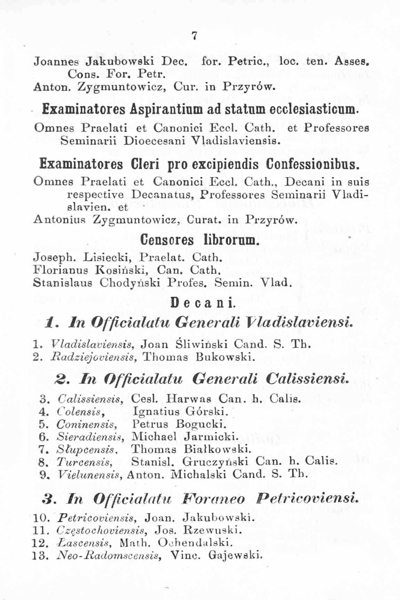

In [30]:
from core.models.lmv3.model import ocr_page
result = ocr_page(sample, text_only=True)
print(result)
display(sample.resize((400, 600)))

In [ ]:
run = wandb.init(
    project="document-parsing-evaluation",
    job_type="evaluation",
    config={
        "llm_model": "name_of_your_llm_model", # e.g., gpt-4o, claude-3-opus
        "lmv3_model": "name_of_your_lmv3_model", # e.g., Donut, LayoutLMv3
        "dataset": "path/to/your/filtered_dataset",
        "skipping_files": len(skipping)
    }
)

# W&B: 3. Create a wandb.Table to store detailed results for each sample
# We define the columns once, before the loop.
main_columns = [
     "image", "filename", "ground_truth", "llm_prediction", "lmv3_prediction", "metrics"
]

metrics_columns = ["f1_parish", "f1_dedication", "f1_building_material", "f1_page_number", "f1_deanery",]



# W&B: 4. Create a dictionary to accumulate metrics for a final summary
total_metrics = {
    "page_number": {"TP": 0, "FP": 0, "FN": 0},
    "deanery": {"TP": 0, "FP": 0, "FN": 0},
    "parish": {"TP": 0, "FP": 0, "FN": 0},
    "dedication": {"TP": 0, "FP": 0, "FN": 0},
    "building_material": {"TP": 0, "FP": 0, "FN": 0},
}


main_table = wandb.Table(columns=main_columns)

skipping = ["chelmno_1871_0001.jpg"]
for idx, sample in enumerate(tqdm(filtered_dataset, desc="Scanning and Evaluating")):
    filename = sample["image"]
    
    if filename in skipping:
        continue
    
    gt_json = parse_df_to_json(df[df["file_name"] == filename])

    words, bboxes, labels = sample["words"], sample["bboxes"], sample["labels"]
    # repaired_labels = repair_bio_labels(labels)
    # sample_json = build_page_json(words=words, bboxes=bboxes, labels=repaired_labels)

    if len(gt_json["entries"]) == 0:
        continue

    image_pil = sample["image_pil"]

    # --- Model Prediction Section ---
    lmv3_response = lmv3_model.predict(image_pil)
    if filename not in cache:
        llm_response = llm_model.predict(image_pil, hints=lmv3_response)
        cache[filename] = llm_response
    else:
        llm_response = cache[filename]

    parsed_predictions = translate_page(llm_response, parser)
    
    # --- Evaluation ---
    metrics = evaluate_json_response(parsed_predictions, gt_json)


    # --- W&B: 5. Logging section (replaces your print statements) ---

    # A. Log scalar metrics for live plotting
    log_data = {}
    for field, scores in metrics.items():
        # Flatten the metrics for easier plotting, e.g., "metrics/parish/precision"
        log_data[f"metrics/{field}/precision"] = scores.get("precision", 0)
        log_data[f"metrics/{field}/recall"] = scores.get("recall", 0)
        log_data[f"metrics/{field}/TP"] = scores.get("TP", 0)
        log_data[f"metrics/{field}/FP"] = scores.get("FP", 0)
        log_data[f"metrics/{field}/FN"] = scores.get("FN", 0)

        # Accumulate totals for final summary
        total_metrics[field]["TP"] += scores.get("TP", 0)
        total_metrics[field]["FP"] += scores.get("FP", 0)
        total_metrics[field]["FN"] += scores.get("FN", 0)

    # The `step` argument ensures W&B knows this is a time series.
    wandb.log(log_data, step=idx)

    # B. Add a row to our detailed evaluation table
    eval_table.add_data(
        filename,
        wandb.Image(image_pil),
        json.dumps(gt_json, indent=2, ensure_ascii=False),
        json.dumps(parsed_predictions, indent=2, ensure_ascii=False),
        metrics["parish"]["precision"],
        metrics["parish"]["recall"],
        metrics["dedication"]["precision"],
        metrics["dedication"]["recall"],
        metrics["building_material"]["precision"],
        metrics["building_material"]["recall"],
        metrics["page_number"]["precision"],
        metrics["page_number"]["recall"]
    )


# --- W&B: 6. After the loop, log the summary metrics and the complete table ---

# A. Calculate and log final micro-averaged metrics
summary_metrics = {}
for field, counts in total_metrics.items():
    tp, fp, fn = counts["TP"], counts["FP"], counts["FN"]
    summary_metrics[f"summary/{field}/precision"] = tp / (tp + fp) if (tp + fp) > 0 else 0
    summary_metrics[f"summary/{field}/recall"] = tp / (tp + fn) if (tp + fn) > 0 else 0
wandb.log(summary_metrics)


# B. Log the complete table to your run. It will appear in the "Artifacts" or "Media" tab.
wandb.log({"evaluation_results": eval_table})

# W&B: 7. Finish the run
wandb.finish()

In [ ]:
from PIL import ImageDraw, ImageFont

def unnormalize_bbox(bbox, image_width, image_height):
    """
    Convert normalized bbox [0-1000] back to pixel coordinates.
    
    Args:
        bbox: [x1, y1, x2, y2] in normalized coordinates (0-1000)
        image_width: Width of the image in pixels
        image_height: Height of the image in pixels
    
    Returns:
        [x1, y1, x2, y2] in pixel coordinates
    """
    return [
        bbox[0] * image_width / 1000,
        bbox[1] * image_height / 1000,
        bbox[2] * image_width / 1000,
        bbox[3] * image_height / 1000
    ]

def visualize_bboxes(image, words, bboxes, labels, output_path=None):
    """
    Simple function to draw bounding boxes on an image.
    
    Args:
        image: PIL Image object
        words: List of words/tokens
        bboxes: List of normalized bboxes [0-1000 scale]
        labels: List of labels
        output_path: Optional path to save the image
    
    Returns:
        PIL Image with drawn bboxes
    """
    # Convert to RGB if needed
    image = image.convert("RGB")
    draw = ImageDraw.Draw(image)
    
    # Try to load a font
    try:
        font = ImageFont.truetype("Arial", 10)
    except:
        font = ImageDraw.getfont()
    
    # Color mapping for different labels
    colors = {
        'B-parish': 'red',
        'I-parish': 'darkred',
        'B-dedication': 'blue', 
        'I-dedication': 'darkblue',
        'B-building_material': 'green',
        'I-building_material': 'darkgreen',
        'B-page_number': 'purple',
        'I-page_number': 'darkpurple',
        'O': 'gray'
    }
    
    # Get image dimensions
    img_width, img_height = image.size
    
    # Draw each bbox
    for word, bbox, label in zip(words, bboxes, labels):
        # Skip 'O' labels if you want to focus on entities only
        if label == 'O':
            continue
            
        # Convert normalized bbox to pixel coordinates
        pixel_bbox = unnormalize_bbox(bbox, img_width, img_height)
        
        # Get color for this label
        color = colors.get(label, 'yellow')
        
        # Draw the bounding box
        draw.rectangle(pixel_bbox, outline=color, width=2)
        
        # Draw label text above the box
        text = f"{label}: {word}"
        text_y = max(0, pixel_bbox[1] - 15)
        
        # Draw text with white background for visibility
        text_bbox = draw.textbbox((pixel_bbox[0], text_y), text, font=font)
        draw.rectangle(text_bbox, fill='white')
        draw.text((pixel_bbox[0], text_y), text, fill=color, font=font)
    
    # Save if output path provided
    if output_path:
        image.save(output_path)
    
    return image

# Example usage with your data:


In [ ]:
sample_file_name = sample["image"]

In [ ]:
df[df["file_name"] == sample_file_name]

In [ ]:
dataset.features

In [ ]:
print(set(building_material_variants))

In [ ]:
# ---------------------------
# building_materials.py
# ---------------------------

import re
from pathlib import Path
import csv

# ──────────────────────────────────────────────────────────────
# 1) Canonical sets (normalised, no punctuation, lowercase)
# ──────────────────────────────────────────────────────────────
WOOD = {
    "lig", "lign", "ligno", "lignea", "lig", "ligo", "lignum",  # core roots
    "exlig", "exlign", "exligno", "ec_lig",                     # compound / prefixed
}
BRICK = {
    "mur","mu", "muro", "murata", "exmuro", "m",
}
MIXED = {
    "mur_et_lign", "partim_mur", "partim_murata_partim_lign"
}
GENERIC = {
    "eduro_materiali", "duro_materiah",
}

VALID = WOOD | BRICK | MIXED | GENERIC

# ──────────────────────────────────────────────────────────────
# 2) Normalisation helpers
# ──────────────────────────────────────────────────────────────
PUNCT = re.compile(r"[.,;:\-_\s]+")

def normalise(raw: str | None) -> str:
    """
    Lower-case, strip whitespace, remove punctuation and diacritics.
    None -> '' so it fails validation.
    """
    if raw is None:
        return ""
    # quick & dirty latin ascii-only fold; tweak if you expect accents
    txt = raw.lower()
    txt = PUNCT.sub("", txt)
    return txt

def classify(raw: str | None) -> str:
    tok = normalise(raw)
    has_brick = any(x in tok for x in BRICK)
    has_wood = any(x in tok for x in WOOD)
    if has_brick and has_wood:
        return "mixed"
    if has_brick:
        return "brick"
    if has_wood:
        return "wood"
    if any(x in tok for x in GENERIC):
        return "generic"
    return "unknown"


In [ ]:
# ---------------------------
# validate_dataset.py
# ---------------------------

import json


def flag_bad_rows(dataset, report_path: str | Path | None = None):
    """Iterates over HF dataset (or list of dicts) and returns list of bad indices.

    Optionally writes a CSV report:  idx,page_id,bad_value
    """
    bad_samples = []
    csv_rows = []

    for idx, sample in enumerate(tqdm(dataset, desc="Scanning dataset")):
        words, bboxes, labels = sample["words"], sample["bboxes"], sample["labels"]
        repaired_labels = repair_bio_labels(labels)
        gt_json = build_page_json(words=words, bboxes=bboxes, labels=repaired_labels)

        for entity in gt_json["entries"]:
            bm_raw = entity.get("building_material")
            
            if bm_raw is None:
                continue  # might be None
            
            if classify(bm_raw) == "unknown":
                bad_samples.append(idx)
                csv_rows.append(
                    {
                        "idx": idx,
                        "page_id": sample["image"],
                        "bad_value": bm_raw,
                    }
                )
                # break if you only need flag once per page
                break

    # Optional report
    if report_path:
        with open(report_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=["idx", "page_id", "bad_value"])
            writer.writeheader()
            writer.writerows(csv_rows)
        print(f"[INFO] Wrote {len(csv_rows)} flagged rows → {report_path}")

    print(f"[SUMMARY] {len(bad_samples)} / {len(dataset)} samples need review.")
    return bad_samples


def get_unique_values(dataset):
    unique_values = {}
    for idx, sample in enumerate(tqdm(dataset, desc="Scanning dataset")):
        words, bboxes, labels = sample["words"], sample["bboxes"], sample["labels"]
        repaired_labels = repair_bio_labels(labels)
        sample_json = build_page_json(words=words, bboxes=bboxes, labels=repaired_labels)
        for entity in sample_json["entries"]:
            for key, value in entity.items():
                if key not in unique_values:
                    unique_values[key] = set()
                unique_values[key].add(value)
    return unique_values

In [ ]:
unique_values = get_unique_values(filtered_dataset)

In [ ]:
unique_values.keys()


In [ ]:
unique_values["parish"]

In [ ]:
bad_samples = flag_bad_rows(filtered_dataset, report_path="bad_samples.csv")

In [ ]:
bad_samples

In [ ]:
len(bad_samples)

In [ ]:
%load_ext autoreload
%autoreload 2

from data.utils import build_page_json, repair_bio_labels
from tqdm import tqdm

cache = {}
for idx, sample in enumerate(tqdm(filtered_dataset, desc="Evaluating dataset")):
    file_name = sample["image"]
    if "wloclawek" not in file_name:
        continue



    words, bboxes, labels = sample["words"], sample["bboxes"], sample["labels"] 


    repaired_labels = repair_bio_labels(labels)

    gt_json = build_page_json(
        words=words,
        bboxes=bboxes,
        labels=repaired_labels,
    )
    if len(gt_json["entries"]) == 0:
        continue

    lmv3_preds = lmv3_model.predict(sample["image_pil"])
    llm_preds = llm_model.predict(sample["image_pil"], hints=lmv3_preds)
    # words_preds, bboxes_preds, preds = lmv3_model.predict(sample["image_pil"], raw_preds=True)

    # repaired_preds = repair_bio_labels(preds)
    metrics = evaluate_json_response(gt_json, llm_preds)


    display(sample["image_pil"].resize((400, 600)))
    print("-" * 50)
    print(f"File: {file_name}")
    print(f"Preds: {json.dumps(llm_preds, indent=4, ensure_ascii=False)}")
    print(f"GT: {json.dumps(gt_json, indent=4, ensure_ascii=False)}")
    print(f"LMV3 preds: {json.dumps(lmv3_preds, indent=4, ensure_ascii=False)}")
    print("Metrics:")
    print(json.dumps(metrics, indent=4, ensure_ascii=False))

    cache_entry = {
        "predictions": llm_preds,
        "metrics": metrics,
    }


    print(metrics)

    cache[file_name] = cache_entry


    # visualization = visualize_bboxes(
    #         image=sample["image_pil"],
    #         words=words_preds,
    #         bboxes=bboxes_preds, 
    #         labels=repaired_preds,
    #     )
    # display(visualization)




In [ ]:
cache2 = cache.copy()

In [ ]:
# Calculate overall metrics across all images
total_metrics = {}

# Initialize metrics structure for each field
fields = ["page_number", "deanery", "parish", "dedication", "building_material"]
for field in fields:
    total_metrics[field] = {
        "TP": 0,
        "FP": 0, 
        "FN": 0,
        "precision": 0.0,
        "recall": 0.0
    }

# Sum up metrics across all images
for image_name, image_data in cache2.items():
    metrics = image_data["metrics"]
    for field in fields:
        field_metrics = metrics[field]
        total_metrics[field]["TP"] += field_metrics["TP"]
        total_metrics[field]["FP"] += field_metrics["FP"]
        total_metrics[field]["FN"] += field_metrics["FN"]

# Calculate precision and recall for each field
for field in fields:
    tp = total_metrics[field]["TP"]
    fp = total_metrics[field]["FP"]
    fn = total_metrics[field]["FN"]
    
    # Calculate precision
    if tp + fp > 0:
        total_metrics[field]["precision"] = tp / (tp + fp)
    else:
        total_metrics[field]["precision"] = 0.0
        
    # Calculate recall
    if tp + fn > 0:
        total_metrics[field]["recall"] = tp / (tp + fn)
    else:
        total_metrics[field]["recall"] = 0.0

print("Overall metrics:")
print(json.dumps(total_metrics, indent=4))


In [ ]:
print(json.dumps(llm_preds, indent=4, ensure_ascii=False))

In [ ]:
import pytesseract
import numpy as np

In [ ]:
%load_ext autoreload
%autoreload 2
from logger.setup import setup_logging
setup_logging()
from llm.interface import LLMInterface
interface3 = LLMInterface(interface_config=config2.predictor)

In [ ]:
%load_ext autoreload
%autoreload 2

from shared import CONFIGS_DIR
from hydra import compose, initialize_config_dir
tests_config_dir = CONFIGS_DIR / "llm"
with initialize_config_dir(config_dir=str(tests_config_dir), job_name="test", version_base="1.1"):
    config2 =  compose(config_name="evaluation_config")

    
from dataset.stats import evaluate_entries, evaluate_json_response
from lmv3.utils.inference_utils import retrieve_predictions

from dataset.stats import evaluate_entries
from dataset.visualize import visualize_entity_boxes
from llm.interface import LLMInterface

interface = LLMInterface(interface_config=config2.predictor)

print("Using config:")
print(config2)

cached_preds = {}

for sample in dataset_batch:
    file_name = sample[config2.dataset.file_name_column_name]
    pil_image = sample[config2.dataset.image_column_name]
    words = sample[config2.dataset.text_column_name]
    bboxes = sample[config2.dataset.boxes_column_name]
    labels = sample[config2.dataset.label_column_name]
    
    
    weight, height = pil_image.size

    print("-" * 50)
    print(f"File: {file_name}")
    

    
    page_json = build_page_json(
        words=words,
        bboxes=bboxes,
        labels=labels,
    )
    
    dummy_page_json = page_json.copy()
    


    
    # visualization = visualize_entity_boxes(pil_image, bboxes, labels, words)
    # display(visualization.resize((400, 600)))
    
    # for word, label, bbox in zip(words, labels, bboxes):
    #     if label == "O":
    #         continue
    #     else:
    #         print(f"{word} - {label}-{bbox}")
    # response = interface.generate_vision_response(
    #         pil_image=pil_image,
    #         system_prompt="system.j2",
    #         user_prompt="user.j2",
    #     )
    # if len(page_json.get("entries")) == 0:
    #     print("No entries found in page JSON, skipping...")
    #     continue 
    
    
    ocr = pytesseract.image_to_data(
            np.array(pil_image.convert("L")),
            output_type=pytesseract.Output.DICT,
            lang="lat+pol+rus",
            config="--psm 6 --oem 3",
        )

    words, norm_boxes, confs = [], [], []

    for i in range(len(ocr["text"])):
        if ocr["level"][i] != 5:
            continue
        word = ocr["text"][i].strip()
        if not word or int(ocr["conf"][i]) < 0:       # skip blanks & “-1” conf
            continue

        xmin, ymin = ocr["left"][i],  ocr["top"][i]
        xmax, ymax = xmin + ocr["width"][i], ymin + ocr["height"][i]

        # ──► NORMALISE to 0-1000
        box = [
            int(1000 * xmin / weight),
            int(1000 * ymin / height),
            int(1000 * xmax / weight),
            int(1000 * ymax / height),
        ]

        norm_boxes.append(box)
        words.append(word)
        confs.append(float(ocr["conf"][i]))
        
    boxes, pred_ids, words = retrieve_predictions(
        image=pil_image,
        processor=processor,
        model=model,
        words=words,
        bboxes=norm_boxes,
    )    
    
    preds = [id2label[pred_id] for pred_id in pred_ids]
    
    lmv3_page_json = build_page_json(
        words=words,
        bboxes=boxes,
        labels=preds,
    )

    if not file_name in cached_preds:
        print(f"Generating response for {file_name}")
        response, messages = interface.generate_vision_response(
            pil_image=pil_image,
            system_prompt="system.j2",
            user_prompt="user.j2",
            context={"hints": json.dumps(lmv3_page_json, indent=2, ensure_ascii=False)},
        )
        cached_preds[file_name] = response
    else:
        print(f"Using cached response for {file_name}")
        response = cached_preds[file_name]
        

    print(f"Ground Truth: {json.dumps(dummy_page_json, indent=2, ensure_ascii=False)}")
    print(f"LLM response: {response}")
    print(f"LMV3 response: {json.dumps(lmv3_page_json, indent=2, ensure_ascii=False)}")

    predictions = json.loads(response)
    
    print(response)
    # tp, fp, fn = evaluate_entries(
    #     pred_entries=predictions.get("entries", []),
    #     gt_entries=dummy_page_json.get("entries", []),
    # )
    # print(f"True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}")
 
    metrics = evaluate_json_response(
        pred_json= predictions,
        gt_json=page_json
    )
    
    
    print(f"Metrics: {json.dumps(metrics, indent=2, ensure_ascii=False)}")
 
    # print(f"Page JSON: {json.dumps(page_json, indent=2, ensure_ascii=False)}")


    
    

In [ ]:
print(messages[1]["content"][0]["text"])

In [ ]:
# dataset_evaluator.evaluate_dataset(
#     dataset=dataset_batch
# )

In [ ]:
ds2 = ds2.skip(10).take(10)
mini = list(ds2)
print([sample["image"] for sample in mini])

In [ ]:
ds2 = ds2.shuffle(seed=2025)
         # 1 random row


In [ ]:
mini

In [ ]:
cached_preds = {}

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Quick-and-dirty fixer for the Latin → Polish mapping.

• Drop your original JSON next to this script (name: parsed_saints_mapping.json)
• Run:   python fix_saints.py
• Inspect saints_mapping_fixed.json + the console diff
"""

import json, re, unicodedata
from pathlib import Path

# ---------- 1.  generic clean-ups (regex & char maps) ------------------------

CYRILLIC_TO_LAT = str.maketrans(
    "АВСЕНКМОРТХаеосурх",
    "ABCEHKMOPTHaeosypx"   # visually closest ASCII
)

GENERIC_RULES = [
    # digit “5” that should be “S.”
    (re.compile(r'\b5\.'), 'S.'),
    # stray em-dash at start “— T. …”
    (re.compile(r'^—\s*'), ''),
    # remove soft hyphen splits “Ni- colaum” → “Nicolaum”
    (re.compile(r'(\w)-\s+(\w)'), r'\1\2'),
    # double periods
    (re.compile(r''), '.'),
    # collapse whitespace
    (re.compile(r'\s+'), ' '),
]

def auto_fix(key: str) -> str:
    s = unicodedata.normalize('NFKD', key)      # strip ligatures / accents
    s = s.translate(CYRILLIC_TO_LAT)            # Cyrillic → Latin look-alikes
    for pat, repl in GENERIC_RULES:
        s = pat.sub(repl, s)
    return s.strip()

# ---------- 2.  specific hard-coded repairs you asked for --------------------

MANUAL_FIXES = {
    # obvious OCR drop-outs / missing letters
    "Tranfiguratio D. N. J. C.": "Transfiguratio D. N. J. C.",
    "sumptio B. M. V.":          "Assumptio B. M. V.",
    "latio 5. Stanislai E. M.":  "Translatio S. Stanislai E. M.",
    "Ni- colaum.E.":             "S. Nicolaum E.",
    "Еха@. S. Crue.":            "Exaltatio S. Crucis.",  # @ → alt-o, e→i
    "Ехай. S. Crue.":           "Exaltatio S. Crucis.",
    "Езай. S. Crucis":          "Exaltatio S. Crucis.",
    "S. Zaurent. M.":            "S. Laurentius M.",
    "S. pan M.":                 "S. Laurentius M.",
    "Transf. Dni":               "Transfiguratio D. N. J. C.",
    "Transf. Dni":               "Transfiguratio D. N. J. C.",
    "55. Trinitatis":            "SS. Trinitatis.",
    "5S. Trinit.":               "SS. Trinit.",
    "SS. Trist.":                "SS. Trinit.",
    "SS. Туи.":                  "SS. Trinit.",
    "SS. Гей.":                 "SS. Trinit.",
    "SS. vetri ct Pauli Ap.":    "SS. Petri et Pauli Ap.",
    "SS. petr. et Paul. Ap.":    "SS. Petri et Pauli Ap.",
    "Праepos. Joan. Śliwiński. Cand. S. Theol. Decan. Re- gens Cancel. Administr. Dioec. natus 21 No-":
                                 "S. Joannes Bapt.",
    "S. ‚Jacob. Ap.":            "S. Jacobus Ap.",
    # feel free to extend this dict as you spot others
}

# ---------- 3.  run cleaning pass -------------------------------------------

RAW_FILE  = Path("parsed_saints_mapping.json")
OUT_FILE  = Path("saints_mapping_fixed.json")

with RAW_FILE.open(encoding="utf-8") as f:
    data = json.load(f)

fixed = {}
touched = []          # for a quick diff in console

for bad_lat, pl in data.items():
    new_lat = MANUAL_FIXES.get(bad_lat, auto_fix(bad_lat))
    fixed[new_lat] = pl
    if new_lat != bad_lat:
        touched.append((bad_lat, new_lat))

# ---------- 4.  save & show what changed ------------------------------------

with OUT_FILE.open("w", encoding="utf-8") as f:
    json.dump(fixed, f, ensure_ascii=False, indent=2)

print(f"✨  Wrote {OUT_FILE}  ({len(touched)} keys changed)\n")
for old, new in touched:
    print(f"• {old}   →   {new}")
  "S. Cathar. VM.": "Katarzyna Panna Męczennica",


In [ ]:
#import progressbar lib
from tqdm import tqdm

In [ ]:
"""
Enhanced W&B logging script (v2)
────────────────────────────────
Logs **per‑field** metrics.
Creates two tables:
1. **page_metrics** – one row per example. Columns:
   file_name + for every field → TP, FP, FN, precision, recall, f1
   (e.g. deanery_TP, deanery_f1, parish_precision …)
2. **aggregate_metrics** – mean / max / min for every numeric column above.
"""

import json
from datetime import datetime
from statistics import mean

import numpy as np
import pytesseract
import wandb

from dataset.stats import evaluate_json_response
from lmv3.utils.inference_utils import retrieve_predictions

# ──────────────────────────────────────────────────────────────────────────────
# Init W&B
# ──────────────────────────────────────────────────────────────────────────────
wandb_run = wandb.init(
    project="document_extraction",
    name=f"lmv3_eval_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    notes="LMv3 + GPT‑4o – per‑field metrics",
    config={
        "model": getattr(model, "name", "lmv3"),
    },
)

# ──────────────────────────────────────────────────────────────────────────────
# Helper functions
# ──────────────────────────────────────────────────────────────────────────────

def field_f1(p, r):
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0


def flatten_field_metrics(metrics_dict: dict) -> dict:
    """Return flat {field_metric: value} including f1 for each field."""
    flat = {}
    for field, m in metrics_dict.items():
        prec, rec = m["precision"], m["recall"]
        flat.update({
            f"{field}_TP": m["TP"],
            f"{field}_FP": m["FP"],
            f"{field}_FN": m["FN"],
            f"{field}_precision": prec,
            f"{field}_recall": rec,
            f"{field}_f1": field_f1(prec, rec),
        })
    return flat

# ──────────────────────────────────────────────────────────────────────────────
# Evaluation loop
# ──────────────────────────────────────────────────────────────────────────────

rows = []
step = 0

#wrap with tqdm for progress bar
dataset_batch = tqdm(dataset_batch, desc="Evaluating dataset", unit="sample")

for sample in dataset_batch:
    step += 1

    file_name = sample[config2.dataset.file_name_column_name]
    pil_image = sample[config2.dataset.image_column_name]
    words = sample[config2.dataset.text_column_name]
    bboxes = sample[config2.dataset.boxes_column_name]
    labels = sample[config2.dataset.label_column_name]

    width, height = pil_image.size

    # ── Build GT JSON ────────────────────────────────────────────────
    gt_json = build_page_json(words=words, bboxes=bboxes, labels=labels)
    if len(gt_json.get("entries", [])) == 0:
        continue

    # ── OCR words & boxes ────────────────────────────────────────────
    ocr = pytesseract.image_to_data(
        np.array(pil_image.convert("L")),
        output_type=pytesseract.Output.DICT,
        lang="lat+pol+rus",
        config="--psm 6 --oem 3",
    )
    ocr_words, norm_boxes = [], []
    for i, word in enumerate(ocr["text"]):
        if ocr["level"][i] != 5:
            continue
        if not (w := word.strip()) or int(ocr["conf"][i]) < 0:
            continue
        xmin, ymin = ocr["left"][i], ocr["top"][i]
        xmax, ymax = xmin + ocr["width"][i], ymin + ocr["height"][i]
        box = [
            int(1000 * xmin / width),
            int(1000 * ymin / height),
            int(1000 * xmax / width),
            int(1000 * ymax / height),
        ]
        norm_boxes.append(box)
        ocr_words.append(w)

    # ── LMv3 predictions ────────────────────────────────────────────
    boxes, pred_ids, _ = retrieve_predictions(
        image=pil_image,
        processor=processor,
        model=model,
        words=ocr_words,
        bboxes=norm_boxes,
    )
    preds = [id2label[p] for p in pred_ids]
    lmv3_json = build_page_json(words=ocr_words, bboxes=boxes, labels=preds)

    # ── LLM extraction ───────────────────────────────────────────────
    if file_name not in cached_preds:
        resp, _ = interface.generate_vision_response(
            pil_image=pil_image,
            system_prompt="system.j2",
            user_prompt="user.j2",
            # context={"hints": json.dumps(lmv3_json, indent=2, ensure_ascii=False)},
        )
        cached_preds[file_name] = resp
    else:
        resp = cached_preds[file_name]
    pred_json = json.loads(resp)

    # ── Field‑level metrics ──────────────────────────────────────────
    field_metrics = evaluate_json_response(pred_json=pred_json, gt_json=gt_json)
    flat_metrics = flatten_field_metrics(field_metrics)
    row = {"file_name": file_name, 
           "groud_truth": json.dumps(gt_json, ensure_ascii=False),
           "lmv3_response": json.dumps(lmv3_json, ensure_ascii=False),
           "llm_response": json.dumps(pred_json, ensure_ascii=False),
           **flat_metrics}
    rows.append(row)


# ──────────────────────────────────────────────────────────────────────────────
# Build W&B tables
# ──────────────────────────────────────────────────────────────────────────────

if rows:
    columns = list(rows[0].keys())
    page_table = wandb.Table(columns=columns)
    for r in rows:
        page_table.add_data(*[r[c] for c in columns])

    # Aggregate
    numeric_cols = [c for c in columns if c not in ["file_name", "groud_truth", "lmv3_response", "llm_response"]]
    stats = {col: [r[col] for r in rows] for col in numeric_cols}

    agg_table = wandb.Table(columns=["stat"] + numeric_cols)
    for stat_name, fn in {"mean": mean, "max": max, "min": min}.items():
        agg_table.add_data(stat_name, *[fn(stats[col]) for col in numeric_cols])


    wandb.log({
        "page_metrics": page_table,
        "aggregate_metrics": agg_table,
    }, step=step)

wandb_run.finish()


In [ ]:
import openai

api_key = "lm-studio"
api_base = "http://localhost:1234/v1"


client = openai.Client(base_url=api_base, api_key=api_key)

response = client.chat.completions.create(
    model="gemma-3-27b-it-qat",  # replace with your model name
    messages=[
        {"role": "user", "content": "Hello, who are you?"},
    ],
    temperature=0.7,
)




In [ ]:
print(response.choices[0].message.content)

In [ ]:
config

In [ ]:
sample = next(iter(dataset_batch))

In [ ]:
from lmv3.model import LMv3Model
lmv3_model = LMv3Model(config=config2)

In [ ]:
response = lmv3_model.predict(sample["image_pil"])

In [ ]:
response

In [ ]:
print(response)

In [ ]:
from llm.model import LLMModel
llm_model = LLMModel(config=config.predictor)

In [ ]:
response = llm_model.predict(sample["image_pil"])